# Exploring genetic variant effects

This analysis aimed to determine the distribution of variants classified by effect as either deleterious (potentially disease-causing) or neutral according to [PredictSNP2](https://loschmidt.chemi.muni.cz/predictsnp2/).

To achieve this, the following steps were performed:

1. Genetic Variant Effect Data Retrieval and Preparation: Genetic variant effect scores and predictions were retrieved from PredictSNP2. The retrieved data underwent processing and preparation following guidelines outlined in the `Notebooks\Data_preparation\6-Variant_effect_scores_and_predictions.ipynb` Jupyter notebook. The processed data can be found in the `Data\Processed\Variant_effects.csv` file.
2. Data Filtering: To ensure that the variant effect data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.
3. Variant Classification: Variants classified as deleterious or neutral were grouped and counted.
4. Visualisation: To offer insights into the distribution of variant effects for each gene, a stacked bar plot was generated. Additionally, a table was created, organizing the variants based on their level of potential harm, with those predicted to be the most deleterious by various algorithms placed at the top of the table.

## Imports

Notebook setup

In [1]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Import variant effect data

In [2]:
vep_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Variant_effects.csv",
    )
).drop(columns="Unnamed: 0")

vep_data.head(5)

,CHROM,POS,REF,ALT,SGNF,PSNPE,PSNPS,PSNPC,CADDE,CADDS,...,FATS,FATC,FUNE,FUNS,FUNC,GWAVAE,GWAVAS,GWAVAC,ID,GENE
0,13,110148891,C,G,NaN,neutral,-1.000000,0.88,neutral,2.258,...,0.18997,0.77,NaN,NaN,NaN,neutral,0.30,0.68,rs552586867,COL4A1
1,13,110148917,C,G,NaN,neutral,-0.319012,0.74,deleterious,9.461,...,0.18963,0.77,neutral,8.515992e-06,0.80,neutral,0.32,0.71,rs59409892,COL4A1
2,13,110148920,G,C,NaN,neutral,-0.320755,0.74,deleterious,9.779,...,0.21184,0.75,?,6.227860e-01,0.49,neutral,0.32,0.71,rs535182970,COL4A1
3,13,110148959,A,G,Likely benign,deleterious,0.456207,0.91,deleterious,13.690,...,0.82375,0.82,neutral,7.524398e-20,0.80,neutral,0.44,0.53,rs56406633,COL4A1
4,13,110148971,G,C,NaN,neutral,-0.155078,0.73,neutral,6.450,...,0.95264,0.91,deleterious,1.193686e+00,0.74,neutral,0.44,0.53,rs568536001,COL4A1


Import genetic variant data for African populations

In [3]:
ih_afr = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

## Data filtering
To ensure that the variant data represented only Recent African population groups, information on African American and African Caribbean subpopulations was excluded.


In [4]:
# Ensure that variants with recent African alternate counts = 0 are removed as these variants are not present in the African population
ih_recent_afr = ih_afr[(ih_afr["REG"] == "Recent African") & ~(ih_afr["IH_ALT_CTS"] == 0)]

# Select effect data for variants that are in Recent African populations
recent_african_vep_data = ih_recent_afr.merge(vep_data, how="left", left_on=["VAR_NAME", "REF", "ALT", "POS", "GENE"], right_on=["ID", "REF", "ALT", "POS", "GENE"]).drop(columns="ID_y").rename(columns={"ID_x":"ID"})

recent_african_vep_data.head(5)

,Unnamed: 0,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,...,DANNC,FATE,FATS,FATC,FUNE,FUNS,FUNC,GWAVAE,GWAVAS,GWAVAC
0,29,rs552586867,110148891,C,G,COL4A1,NaN,2,1608,110148891_G_C,...,0.82,neutral,0.18997,0.77,NaN,NaN,NaN,neutral,0.30,0.68
1,33,rs59409892,110148917,C,G,COL4A1,NaN,152,1608,110148917_G_C,...,0.62,neutral,0.18963,0.77,neutral,0.000009,0.80,neutral,0.32,0.71
2,203,rs546124548,110149176,T,A,COL4A1,NaN,1,1608,110149176_A_T,...,0.75,?,0.27014,0.48,deleterious,1.378901,0.64,deleterious,0.55,0.80
3,351,rs139916479,110149349,G,A,COL4A1,NaN,7,1608,110149349_A_G,...,0.70,neutral,0.18771,0.77,?,0.756114,0.45,neutral,0.45,0.53
4,387,rs552877576,110149494,C,T,COL4A1,NaN,2,1608,110149494_T_C,...,0.82,deleterious,0.96497,0.92,deleterious,1.193686,0.74,deleterious,0.54,0.78


## Variant Classification
Variants classified as deleterious or neutral were grouped and counted.

In [5]:
# Group dataframe information by gene and effect prediction value

pathogenicity_grouped = (
    recent_african_vep_data.groupby(["GENE", "PSNPE"])
    .count()
    .reset_index()
    .rename(columns={"ID": "COUNT"})[["GENE", "PSNPE", "COUNT"]]
)

# Pivot dataframe

pathogenicity_pivot = pd.pivot(pathogenicity_grouped, index=['GENE'], columns=['PSNPE'], values=['COUNT'])
pathogenicity_pivot.columns = pathogenicity_pivot.columns.droplevel()
pathogenicity_pivot= pathogenicity_pivot.reset_index().rename(columns={"deleterious":"DELETERIOUS", "neutral":"NEUTRAL", "not_classified":"NOT_CLASSIFIED"})

pathogenicity_pivot.head(5)

PSNPE,GENE,DELETERIOUS,NEUTRAL
0,AGT,45,1049
1,AP4B1,28,106
2,CARD8,108,1390
3,CAT,36,463
4,COL4A1,74,3095


In [6]:
# Add total gene variant count information. Use the total count information to calculate the number of variants without effect classifications.

recent_african_gene_count_grouped = ih_recent_afr[["GENE", "ID"]].groupby("GENE").count().rename(columns={"ID":"TOTAL"})

pathogenicity_pivot = pathogenicity_pivot.merge(recent_african_gene_count_grouped, on="GENE").set_index("GENE").reset_index()

pathogenicity_pivot.head(5)

,GENE,DELETERIOUS,NEUTRAL,TOTAL
0,AGT,45,1049,1271
1,AP4B1,28,106,153
2,CARD8,108,1390,2110
3,CAT,36,463,616
4,COL4A1,74,3095,4060


In [7]:
# Calculate number of variants without classifications

pathogenicity_pivot["NOT_CLASSIFIED"] = (pathogenicity_pivot.TOTAL - (pathogenicity_pivot.DELETERIOUS + pathogenicity_pivot.NEUTRAL))
pathogenicity_pivot = pathogenicity_pivot.drop(columns="TOTAL").set_index("GENE")
pathogenicity_pivot.tail(5)

,DELETERIOUS,NEUTRAL,NOT_CLASSIFIED
GENE,,,
IL1B,3,90,17
IL6,12,92,16
MTHFR,21,153,310
NOS3,49,381,114
TNF,7,22,5


## Visualisation

Set plot parameters

In [8]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

A stacked barplot visually representing the distribution of variants classified as deleterious or neutral was created.

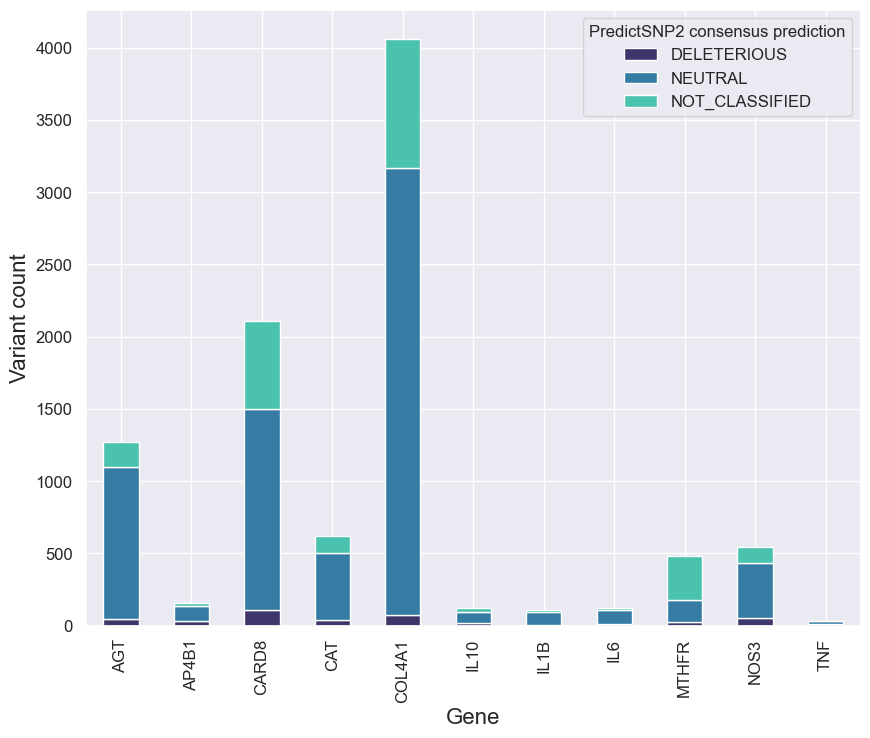

In [14]:
custom_palette = sns.color_palette("mako", 3)
pathogenicity_plot = functions.create_plot(
    data=pathogenicity_pivot,
    plot_type="stacked_barplot",
    palette=custom_palette,
    legend_title="PredictSNP2 consensus prediction",
    legend_loc="upper right",
    x="GENE",
    xlabel="Gene",
    ylabel="Variant count",
    horizontal_stack = False
)

plt.savefig("..\Results\Figures\Gene_deleterious_variant_count.png", dpi=1200)
plt.show()

Variants were organised based on their level of potential harm (impact), with those predicted to be the most deleterious by various algorithms placed at the top of the table.

In [10]:
# Score variants based on number of deleterious effect predictions by various algorithms

vep_scored = vep_data.copy()
vep_scored["VAR_IMPACT"] = vep_scored.eq("deleterious").sum(axis=1)

# Sort by variant impact
af_VEP_scored = vep_scored.sort_values(by="VAR_IMPACT", ascending=False)

af_VEP_scored.head(5)

,CHROM,POS,REF,ALT,SGNF,PSNPE,PSNPS,PSNPC,CADDE,CADDS,...,FATC,FUNE,FUNS,FUNC,GWAVAE,GWAVAS,GWAVAC,ID,GENE,VAR_IMPACT
18872,1,11795156,G,A,NaN,deleterious,1.0,0.87,deleterious,27.3,...,0.56,deleterious,4.0,0.62,deleterious,0.31,0.52,rs371085894,MTHFR,6
14403,1,113898727,T,C,Benign,deleterious,1.0,0.87,deleterious,20.3,...,0.69,deleterious,4.0,0.62,deleterious,0.65,0.51,rs145182838,AP4B1,6
8825,7,151007251,G,A,NaN,deleterious,1.0,0.87,deleterious,21.7,...,0.83,deleterious,4.0,0.62,deleterious,0.34,0.52,rs372783097,NOS3,6
8826,7,151007271,T,C,NaN,deleterious,1.0,0.87,deleterious,21.8,...,0.73,deleterious,4.0,0.62,deleterious,0.32,0.52,rs563391462,NOS3,6
14310,1,113896464,C,G,NaN,deleterious,1.0,0.87,deleterious,21.7,...,0.83,deleterious,4.0,0.62,deleterious,0.34,0.52,chr1:113896464C-G,AP4B1,6


In [12]:
# Save variant impact results

af_VEP_scored.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Results",
        "Tables",
        "Variant_impact.csv",
    )
)